In [26]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

DATA_PATH = r"C:\usecases\Usecases\Mask-PPEDetection\data"

IMG_SIZE = (112, 112)  # small size for low-res dataset


In [27]:

train_ds = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=16
)

val_ds = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=16
)

print("Classes:", train_ds.class_names)


Found 416 files belonging to 2 classes.
Using 333 files for training.
Found 416 files belonging to 2 classes.
Using 83 files for validation.
Classes: ['with_mask', 'without_mask']


In [28]:
normalizer = tf.keras.layers.Rescaling(1.0/255)

train_ds = train_ds.map(lambda x, y: (normalizer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalizer(x), y))


In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base = MobileNetV2(
    input_shape=(112,112,3),
    include_top=False,
    weights="imagenet"
)

base.trainable = False  
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(base.input, output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



C:\Users\arushi.choudhary\AppData\Local\Temp\ipykernel_6284\1828813396.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 391ms/step - accuracy: 0.6967 - loss: 0.5926 - val_accuracy: 0.8193 - val_loss: 0.4320
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.8138 - loss: 0.4378 - val_accuracy: 0.8916 - val_loss: 0.3082
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.8619 - loss: 0.3322 - val_accuracy: 0.9398 - val_loss: 0.2353
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.8829 - loss: 0.2825 - val_accuracy: 0.9639 - val_loss: 0.1880
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9249 - loss: 0.2178 - val_accuracy: 0.9639 - val_loss: 0.1543
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.9489 - loss: 0.1875 - val_accuracy: 0.9880 - val_loss: 0.1281
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9550 - loss: 0.1628 - val_accuracy: 0.9880 - val_loss: 0.1072
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9520 - loss: 0.1673 - val_accuracy: 0

In [31]:
model.save("mask_model_lowres.keras")
print("Model saved!")


Model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


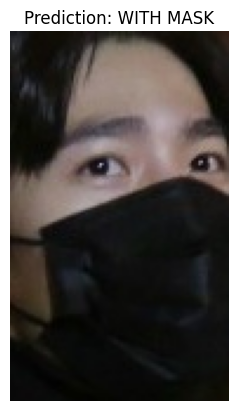

In [33]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# load your model
loaded = tf.keras.models.load_model("mask_model_lowres.keras")

def predict_mask(img_path):
    # read image
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Image not found. Check the path.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # resize to the same size you used in training
    img_resized = cv2.resize(img_rgb, (112,112)) / 255.0

    # prediction
    pred = loaded.predict(np.expand_dims(img_resized, axis=0))[0][0]

    # label
    label = "WITH MASK" if pred < 0.5 else "WITHOUT MASK"

    # show
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {label}")
    plt.axis("off")
    plt.show()

# ---------------------------
# CALL THE FUNCTION
# ---------------------------
predict_mask(r"C:\Users\arushi.choudhary\Documents\with_mask_388.jpg")
